# Team FIFA

---
You are working for an advertising analytics consulting company.  Your client, a name brand television network, needs to re-formulate their pricing structure for advertisement slots during soccer matches for new customers.  They also want this new structure to incentivize existing customers to create new partnerships/sponsors with teams and players.  

**Goals:**
- Determine a reasonable metric to decide how exciting a game is.
    - Engineer this feature using existing data.
- Suggest a pricing structure tied to the overall value associated with "game excitement".

**Presentation requirements:**
- At least 50% of presentation must address a non-technical audience.
- Someone who hasn't presented in class yet must take lead on presentation.

# Import packages + load data 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

%matplotlib inline

In [4]:
df = pd.read_csv("./datasets/fifa_goals.csv")

In [ ]:
df.head(10)

# Cleaning data
### 1. Describe the data we have 

In [8]:
# there is no null values 
df.isnull().sum()

game_id       0
minute        0
player        0
team1score    0
team2score    0
dtype: int64

In [9]:
df.describe(include='all')

,game_id,minute,player,team1score,team2score
count,2207.000000,2207,2207,2207.000000,2207.000000
unique,NaN,117,1226,NaN,NaN
top,NaN,89,MÃ¼ller,NaN,NaN
freq,NaN,39,20,NaN,NaN
mean,428.732216,NaN,NaN,1.754418,0.849570
std,251.548662,NaN,NaN,1.486246,0.914291
min,1.000000,NaN,NaN,0.000000,0.000000
25%,242.000000,NaN,NaN,1.000000,0.000000
50%,422.000000,NaN,NaN,1.000000,1.000000
75%,651.500000,NaN,NaN,2.000000,1.000000


#### This is how the data looks like
**game_id**: Each game is defined by it's unique game_id. <br>
**minute** : The time of the game in which there was a goal <br>
**player** : The player that made the score  <br>
**team1score**: The score at the point of time when the goal is made by team 1  <br>
**team2score**: The score at the point of time when the goal is made by team 2 <br>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 5 columns):
game_id       2207 non-null int64
minute        2207 non-null object
player        2207 non-null object
team1score    2207 non-null int64
team2score    2207 non-null int64
dtypes: int64(3), object(2)
memory usage: 86.3+ KB


In [13]:
#to see what are the values that cause minute column to be a string 
print [i  for i in df['minute'] if i.isdigit() == False]

['90+', '45+', '90+', '90+', '45+', '45+', '90+', '90+', '45+', '45+', '90+', '90+', '90+', '90+', '90+', '45+', '90+', '45+', '45+', '45+', '45+', '90+', '90+', '90+', '90+', '90+', '45+', '90+', '90+', '90+', '90+', '90+', '90+', '45+', '45+', '90+', '45+', '90+', '120+', '90+', '90+', '90+', '90+', '45+', '90+', '90+', '90+', '45+', '90+', '90+', '45+', '90+', '90+', '45+', '90+', '45+', '45+', '45+', '90+']


In [14]:
# the list above describes the 'over time' --> to delete the '+' and make item into int
df['minute'] = [int(i) if i.isdigit()== True else int(i[:-1]) for i in df['minute']]

In [15]:
#now the are in int format 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 5 columns):
game_id       2207 non-null int64
minute        2207 non-null int64
player        2207 non-null object
team1score    2207 non-null int64
team2score    2207 non-null int64
dtypes: int64(4), object(1)
memory usage: 86.3+ KB


# Analyzing the Data
- Metric of how exciting a game is?
- Who is the most exciting player?

#### Metrics of determining what makes a game exciting 
1. Must have goals. It is exciting when someone scores 
2. Fight back --> tension makes it interesting 
3. Small Goal difference. If goal difference is too huge 
#####  Exciting Criteria: >2 goals by end of game, goal_diff <3 at any moment


### 1. Add in columns relevant to our metrics 

In [17]:
# add a column where goaldiff = difference of two scores at any point 
df['goaldiff']= abs(df['team1score']-df['team2score'])

In [18]:
# add a column to count the total no. of goals at any point 
df['totgoals'] = df['team1score']+df['team2score']

In [19]:
df.sample(5)

,game_id,minute,player,team1score,team2score,goaldiff,totgoals
41,8,53,Vincze,3,2,1,5
1049,402,55,Morientes,3,0,3,3
645,274,30,ZsengellÃ©r,4,0,4,4
839,324,52,Chapuisat,1,2,1,3
2023,790,85,Del Piero,1,1,0,2


### 2. Filtering out the data to find 'exciting' games 

In [29]:
# Filtering >2 goals by end of game, goal_diff <3 at any moment
exciting_crit = df[(df['totgoals']>2) & (df['goaldiff'] < 3)]
exciting_crit.head(5)

,game_id,minute,player,team1score,team2score,goaldiff,totgoals
3,1,57,Donelli,3,1,2,4
10,2,93,Schall,2,1,1,3
11,2,109,BiÄan,3,1,2,4
12,2,118,Verriest [p.],3,2,1,5
15,3,43,Voorhoof,1,2,1,3


### 3. Obtain the no. of exciting moments for each game

In [41]:
game_id_moments = exciting_crit['game_id'].value_counts().sort_values(ascending = False)
game_id_moments[:10]

830    9
276    9
21     6
818    6
610    5
130    5
256    5
275    4
38     4
831    4
Name: game_id, dtype: int64

#### How an exciting game looks like:

In [44]:
# Function that plots of graph that shows the goal difference. 
# Ultimately is to show ow an exciting graph looks like 

def exciting_game(index):
    game = df[df['game_id'] == index]
    x = game['minute']
    y = game['goaldiff']
    
    exciting_moments = exciting_crit['game_id'].value_counts()[index]
    
    plt.figure(figsize=(14,6))
    plt.plot(x, y)
    
    # label each point on the graph 
    for i,time in enumerate(game['minute']):
        score1 = game.iloc[i]['team1score']
        score2 = game.iloc[i]['team2score']
        gdiff = game.iloc[i]['goaldiff']
        plt.annotate((score1,score2), xy = (time,gdiff),size = 14)
    
    # titles, axis labels etc. 
    plt.title('Most Exciting Game',size=14)
    plt.ylabel('Goal Difference')
    plt.xlabel('Game Time')
    plt.legend(['No of moments: {}'.format(exciting_moments)])
    
    plt.show();
    
# Note: additional things to do: 
# - To add in a fix x-axis that only shows int number because goals are integers, not float. 
# - to add in half time and full time to show the full picture. 
# - To add in the last goal score even though there may be no goal 

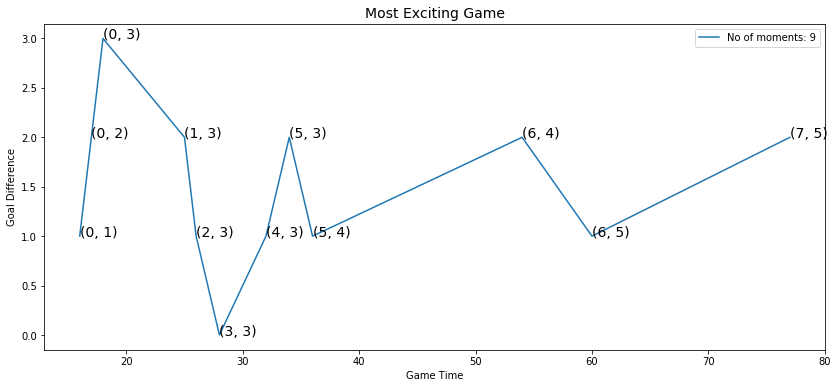

In [45]:
# Game_id = 830 has the highest exciting moments within the game. 
exciting_game(830)

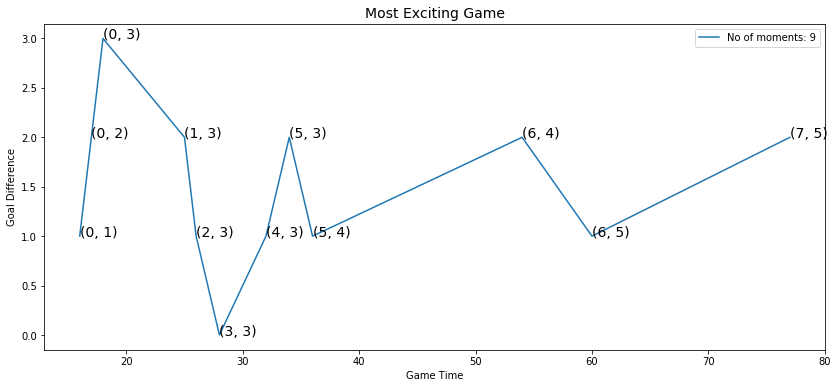

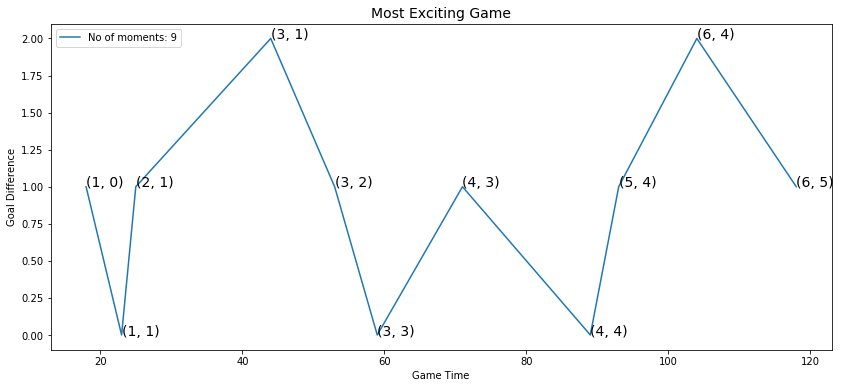

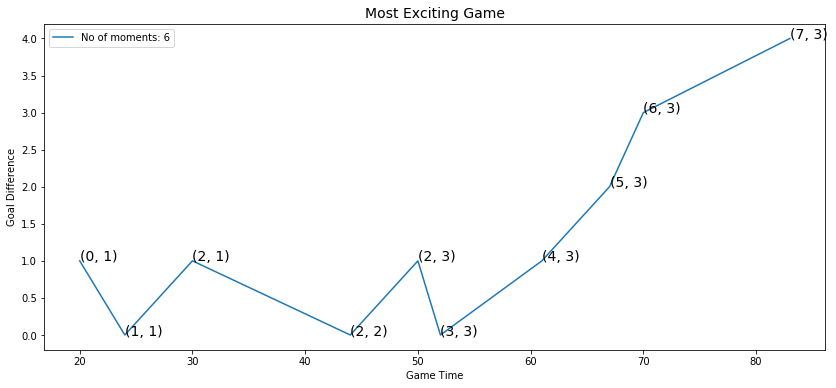

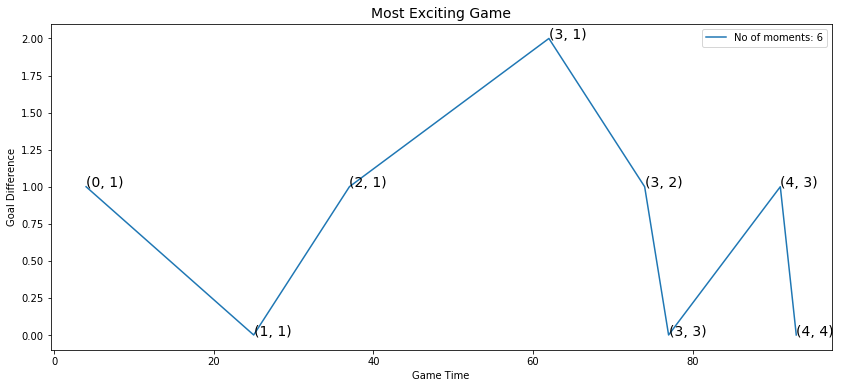

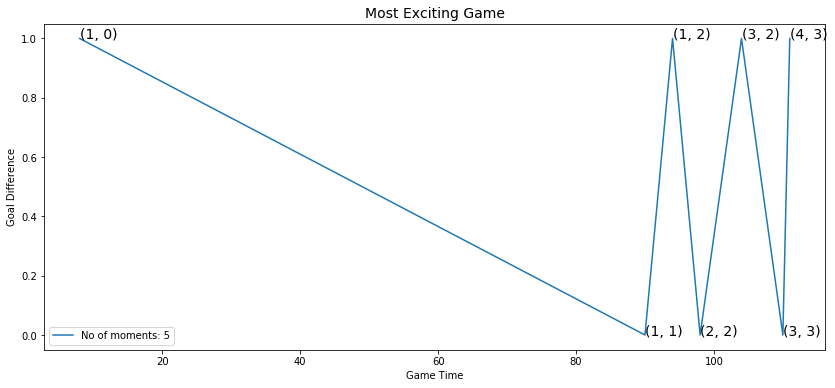

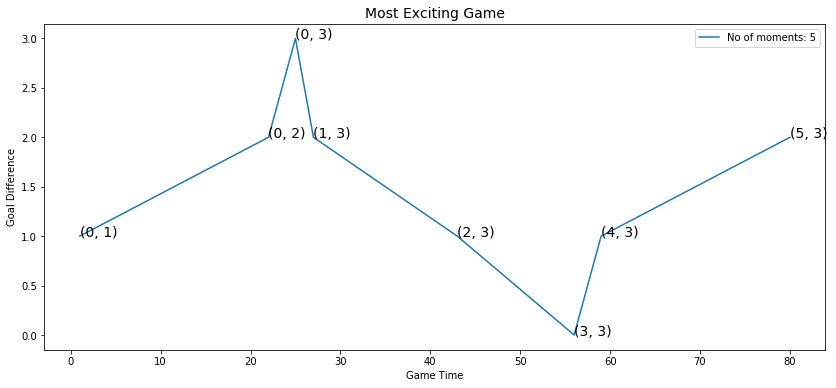

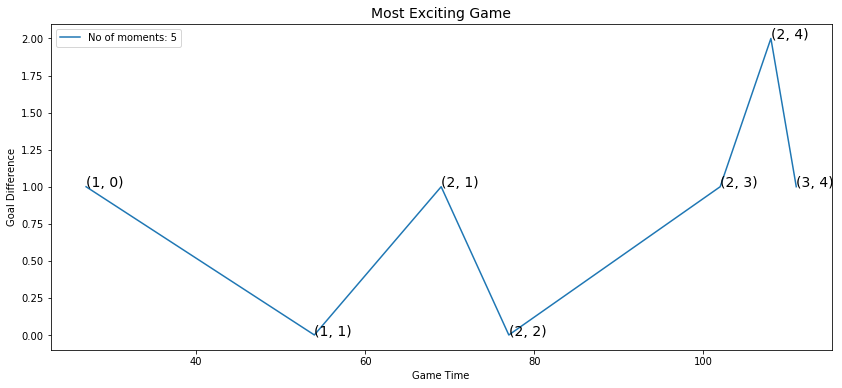

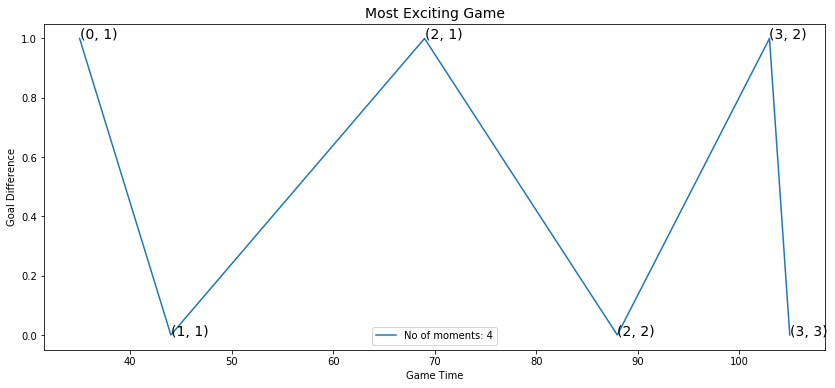

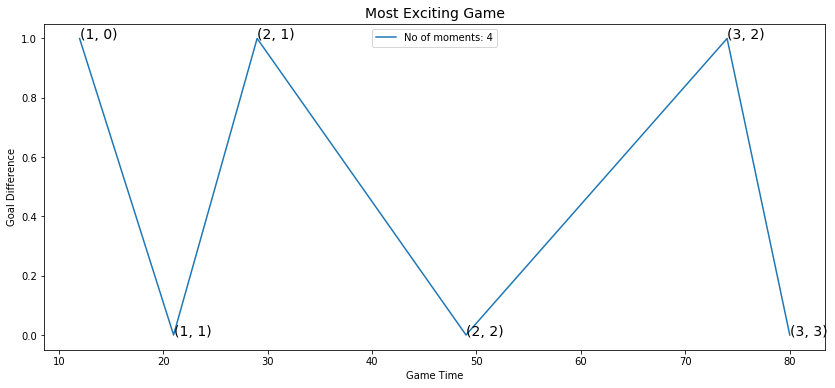

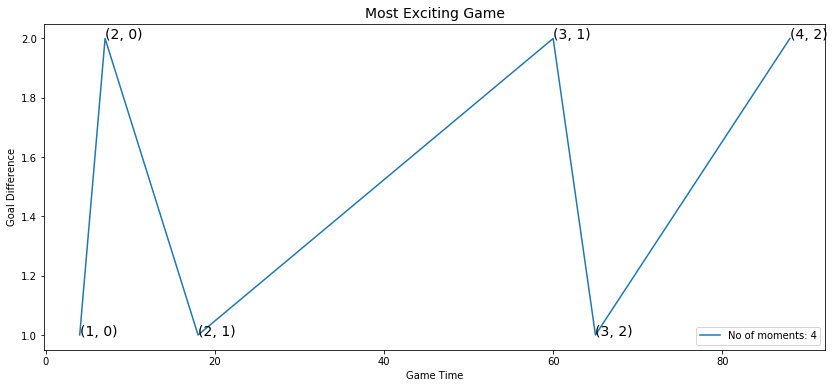

In [48]:
# to print out top 10 most exciting game 
for i in game_id_moments.index[:10]:
    exciting_game(i)

### 4. Determine the categories to map out our price metrics 

In [49]:
for i in range(0,100,5):
    print '{} percentile: {}'.format(i,np.percentile(exciting_crit['game_id'].value_counts(),i))

0 percentile: 1.0
5 percentile: 1.0
10 percentile: 1.0
15 percentile: 1.0
20 percentile: 1.0
25 percentile: 1.0
30 percentile: 1.0
35 percentile: 1.0
40 percentile: 1.0
45 percentile: 1.0
50 percentile: 2.0
55 percentile: 2.0
60 percentile: 2.0
65 percentile: 2.0
70 percentile: 2.0
75 percentile: 2.0
80 percentile: 3.0
85 percentile: 3.0
90 percentile: 3.0
95 percentile: 4.0


Shows the percentile of no. of moments of each game to determine our price metric:

- Cat 1: not part of the 304 teams 
- Cat 2: <50 percentile 1.0
- Cat 3: 50 percentile: 2.0 | 75 percentile: 2.0 | 90 percentile: 3.0
- Cat 4: 95 percentile: 4.0

#### To show this in a form of a graph

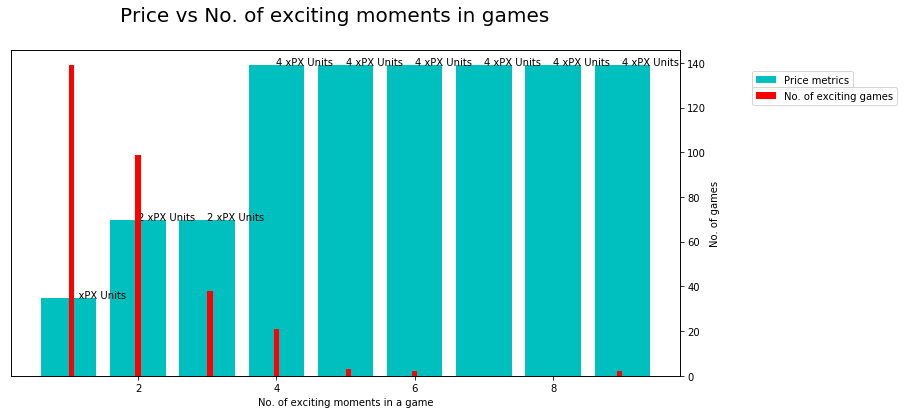

In [62]:
#set up empty plot 
fig,ax1 = plt.subplots(figsize=(12,6))

#plot first graph 
price_x=[1,2,3,4,5,6,7,8,9]
price_y=[1,2,2,4,4,4,4,4,4]
ax1.bar(price_x,price_y,color='c')


for i,val in enumerate(price_y):
    ax1.annotate('{}xPX Units'.format(val),xy=(i+1,val))

ax2 = ax1.twinx()

#plot second graph
x = exciting_crit['game_id'].value_counts()
ax2.hist(x, bins=100,color='r');

#titles, axis labels
fig.suptitle('Price vs No. of exciting moments in games',fontsize = 20)
ax1.set_xlabel('No. of exciting moments in a game')
ax2.set_ylabel('No. of games')
ax1.yaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_locator(plt.NullLocator())

#legend
ax2.legend(['No. of exciting games'],loc='upper left',bbox_to_anchor=(1.1,0.9))
ax1.legend(['Price metrics'],loc='upper left',bbox_to_anchor=(1.1,0.95));




### Want to show this in a form of a exponential graph. and the price metrics is reverse. 
##### so far completely fail. Below is the fail code. 

In [56]:
moments_cat = pd.DataFrame(exciting_crit['game_id'].value_counts().reset_index()['game_id'].value_counts())
moments_cat

,game_id
1,139
2,99
3,38
4,21
5,3
9,2
6,2


In [57]:
moments_cat.sort_index(inplace = True)
moments_cat.index

Int64Index([1, 2, 3, 4, 5, 6, 9], dtype='int64')

In [ ]:
# My code which fails :(
x = moments_cat.index
y = sp.interpolate.interp1d(x,moments_cat['game_id'],kind='quadratic')
plt.plot(x,y)

##### Brian's code. that somehow works but I don't know why yet (13 June 2018) 

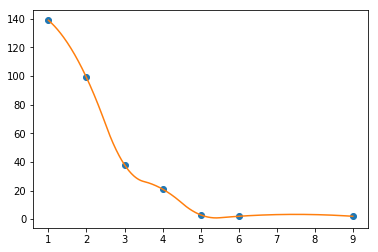

In [63]:
mc_index= [1,2,3,4,5,6,9]
mc_game_id=[139,99,38,21,3,2,2]

moments_cat=pd.DataFrame(mc_index,columns=['_index'])
moments_cat['game_id']=mc_game_id

#print(moments_cat['_index'])

x = moments_cat['_index']
y = moments_cat['game_id']
f = sp.interpolate.interp1d(x, y,kind='quadratic')

xnew = np.linspace(1, 9, 500)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x,y,'o', xnew,ynew)
plt.show()

#### Simple graph that shows the categories 

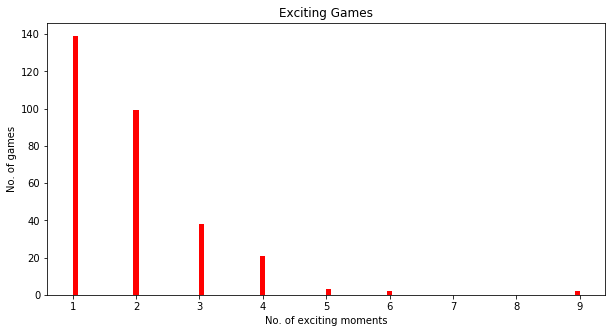

In [66]:
x = exciting_crit['game_id'].value_counts()
plt.figure(figsize = (10,5))
plt.hist(x, bins=100,color='r',);

plt.title('Exciting Games')
plt.xlabel('No. of exciting moments')
plt.ylabel('No. of games');

## Other things to do 
- to get information on how to gather exciting players 